<a href="https://colab.research.google.com/github/melodiw82/FoodClassification_DL/blob/main/FoodClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Downloading The Dataset

In [ ]:
import gdown

file_id = '15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz'
output_file = '/content/train.zip'

if not os.path.exists(output_file):
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

In [ ]:
import zipfile

zip_file_path = '/content/train.zip'
extract_dir = '/content/Data/'

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# Cleaning Corrupted Images

In [ ]:
train_dir = '/content/Data/train'

In [ ]:
subdirectories = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
subdirectories

['/content/Data/train/cheesecake',
 '/content/Data/train/caesar_salad',
 '/content/Data/train/baklava',
 '/content/Data/train/chicken_curry',
 '/content/Data/train/cheese_sandwich',
 '/content/Data/train/chicken',
 '/content/Data/train/donuts',
 '/content/Data/train/pizza',
 '/content/Data/train/hot_dog',
 '/content/Data/train/chocolate_cake',
 '/content/Data/train/baked_potato',
 '/content/Data/train/ice_cream',
 '/content/Data/train/french_fries',
 '/content/Data/train/fish',
 '/content/Data/train/falafel',
 '/content/Data/train/steak',
 '/content/Data/train/lasagna',
 '/content/Data/train/omelette',
 '/content/Data/train/hamburger',
 '/content/Data/train/sushi',
 '/content/Data/train/spaghetti',
 '/content/Data/train/eggs']

In [ ]:
import PIL
from PIL import Image
import os

In [ ]:
# Identify and delete corrupted image in each of the folder file
for folder_path in subdirectories:
  for filename in os.listdir(folder_path):
      try:
          image = Image.open(os.path.join(folder_path, filename))
      except PIL.UnidentifiedImageError as e:
          print(f"Error in file {filename}: {e}")
          os.remove(os.path.join(folder_path, filename))
          print(f"Removed file {filename}")

# Creating The DataFrame

In [ ]:
categories = sorted(os.listdir(train_dir))
categories

['baked_potato',
 'baklava',
 'caesar_salad',
 'cheese_sandwich',
 'cheesecake',
 'chicken',
 'chicken_curry',
 'chocolate_cake',
 'donuts',
 'eggs',
 'falafel',
 'fish',
 'french_fries',
 'hamburger',
 'hot_dog',
 'ice_cream',
 'lasagna',
 'omelette',
 'pizza',
 'spaghetti',
 'steak',
 'sushi']

In [ ]:
df = pd.DataFrame(columns=['image_path', 'label'])
df

,image_path,label


In [ ]:
dfs = []

for category in categories:
    category_path = os.path.join(train_dir, category)
    image_data = []
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_data.append({'image_path': image_path, 'label': category})
    df_category = pd.DataFrame(image_data)
    dfs.append(df_category)

In [ ]:
df = pd.concat(dfs, ignore_index=True)
df

,image_path,label
0,/content/Data/train/baked_potato/521935ed-2bb.jpg,baked_potato
1,/content/Data/train/baked_potato/2a60c989-0ca.jpg,baked_potato
2,/content/Data/train/baked_potato/356d8bf1-8bb.jpg,baked_potato
3,/content/Data/train/baked_potato/60517c93-28a.jpg,baked_potato
4,/content/Data/train/baked_potato/cd26c318-d51.jpg,baked_potato
...,...,...
24079,/content/Data/train/sushi/2653fdb4-9ed.jpg,sushi
24080,/content/Data/train/sushi/4cb50807-a38.jpg,sushi
24081,/content/Data/train/sushi/b9117511-d31.jpg,sushi
24082,/content/Data/train/sushi/fb52c4df-169.jpg,sushi


In [ ]:
df['label'].value_counts()

label
donuts             2395
hamburger          2376
chicken            2288
french_fries       2286
spaghetti          1509
baked_potato       1501
hot_dog            1057
pizza               887
omelette            715
caesar_salad        709
falafel             709
fish                708
cheese_sandwich     708
chicken_curry       707
ice_cream           705
chocolate_cake      702
eggs                699
lasagna             693
sushi               690
steak               681
baklava             680
cheesecake          679
Name: count, dtype: int64

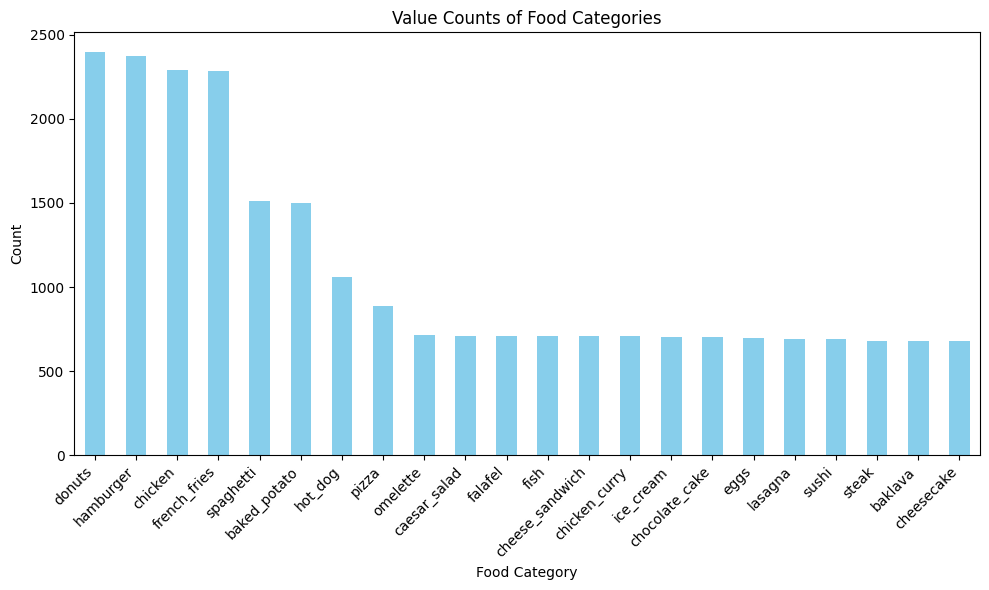

In [ ]:
plt.figure(figsize=(10, 6))

df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Food Category')
plt.ylabel('Count')
plt.title('Value Counts of Food Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The dataset shows class imbalance, where some food categories have many more samples than others. For example, "donuts" and "hamburger" have lots of samples, while "steak" or "cheesecake" have much fewer.

# Computing class weights

In [ ]:
labels = df['label']

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

In [ ]:
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.7293319605111743, 1: 1.6098930481283422, 2: 1.5440441082190024, 3: 1.5462249614791987, 4: 1.6122640246351587, 5: 0.47846471710108074, 6: 1.5484119840555484, 7: 1.5594405594405594, 8: 0.457088631618903, 9: 1.5661334373780726, 10: 1.5440441082190024, 11: 1.5462249614791987, 12: 0.47888332140300643, 13: 0.4607438016528926, 14: 1.0356927840371548, 15: 1.5528046421663444, 16: 1.5796930342384887, 17: 1.5310870947234583, 18: 1.2341908373475454, 19: 0.725465389481294, 20: 1.60752903484181, 21: 1.5865612648221343}


In [ ]:
class_weights

array([0.72933196, 1.60989305, 1.54404411, 1.54622496, 1.61226402,
       0.47846472, 1.54841198, 1.55944056, 0.45708863, 1.56613344,
       1.54404411, 1.54622496, 0.47888332, 0.4607438 , 1.03569278,
       1.55280464, 1.57969303, 1.53108709, 1.23419084, 0.72546539,
       1.60752903, 1.58656126])

# Train_Test Split

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_df.shape

(19267, 2)

In [ ]:
val_df.shape

(4817, 2)

# Image Augmentation

In [ ]:
augmentation_params = {
    'rotation_range': 20,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.2,
    'zoom_range': 0.1,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    **augmentation_params
)

In [ ]:
# additional_augmentation_params = {
#     'rotation_range': 30,
#     'width_shift_range': 0.2,
#     'height_shift_range': 0.2,
#     'shear_range': 0.3,
#     'zoom_range': 0.2,
#     'horizontal_flip': True,
#     'fill_mode': 'nearest'
# }

In [ ]:
# additional_train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     **additional_augmentation_params
# )

In [ ]:
img_size = (224, 224)

In [ ]:
batch_size = 32

In [ ]:
val_datagen = ImageDataGenerator(
    rescale = 1./255
    )

In [ ]:
# additional_generators = []
# threshold = 1000

# class_counts = train_df['label'].value_counts().to_dict()
# for label, count in class_counts.items():
#     if count < threshold:
#         class_rows = train_df[train_df['label'] == label]

#         class_data_generator = additional_train_datagen.flow_from_dataframe(
#             class_rows,
#             x_col='image_path',
#             y_col='label',

#             target_size=img_size,
#             batch_size=batch_size,

#             shuffle=True,
#             seed=42,
#             class_mode='categorical'
#         )

#         additional_generators.append(class_data_generator)

In [ ]:
train_images = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',

    target_size=img_size,
    batch_size=batch_size,

    shuffle=True,
    seed=42,
    class_mode='categorical'
)

Found 19267 validated image filenames belonging to 22 classes.


In [ ]:
val_images = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',

    target_size=img_size,
    batch_size=batch_size,

    shuffle=False,
    seed=42,
    class_mode='categorical'
)

Found 4817 validated image filenames belonging to 22 classes.


# Visualize Some Images From Different Categories

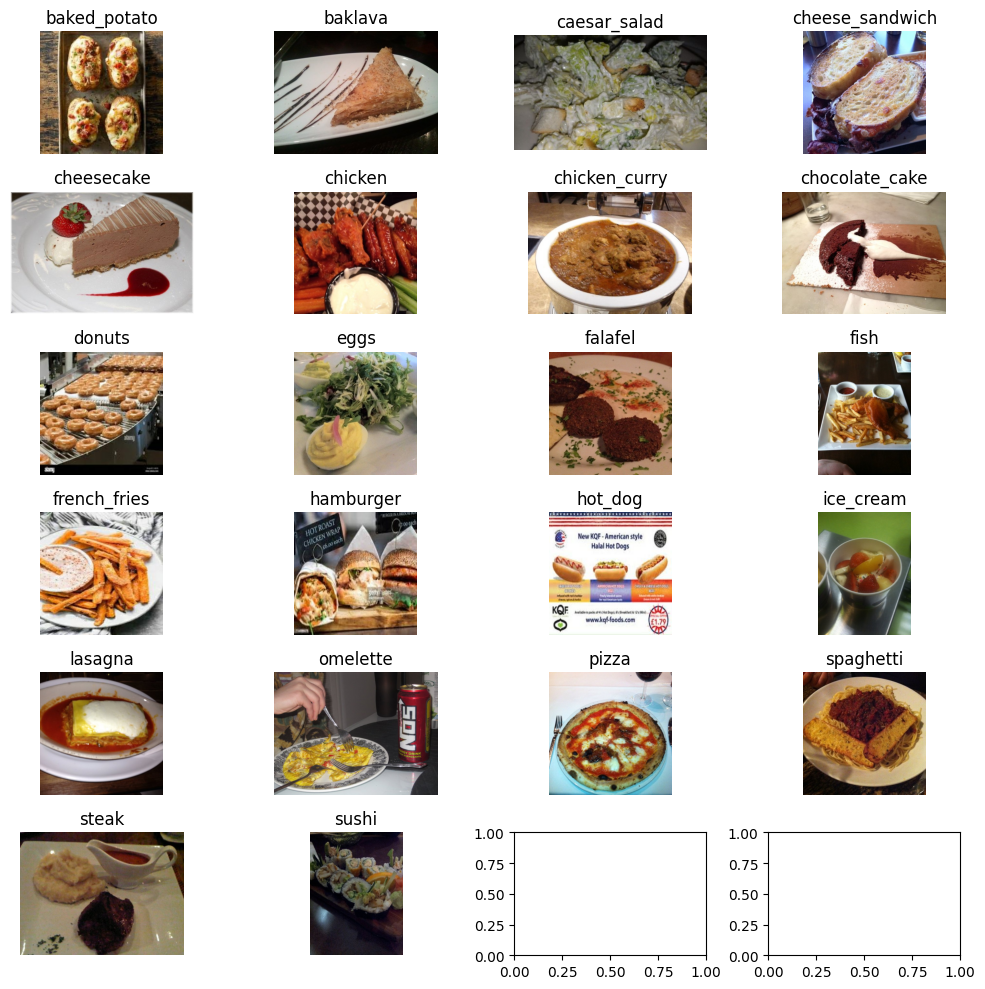

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(10, 10))
axes = axes.flatten()

for i, category in enumerate(categories):
    category_df = train_df[train_df['label'] == category]
    image_path = category_df.iloc[100]['image_path']
    img = plt.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

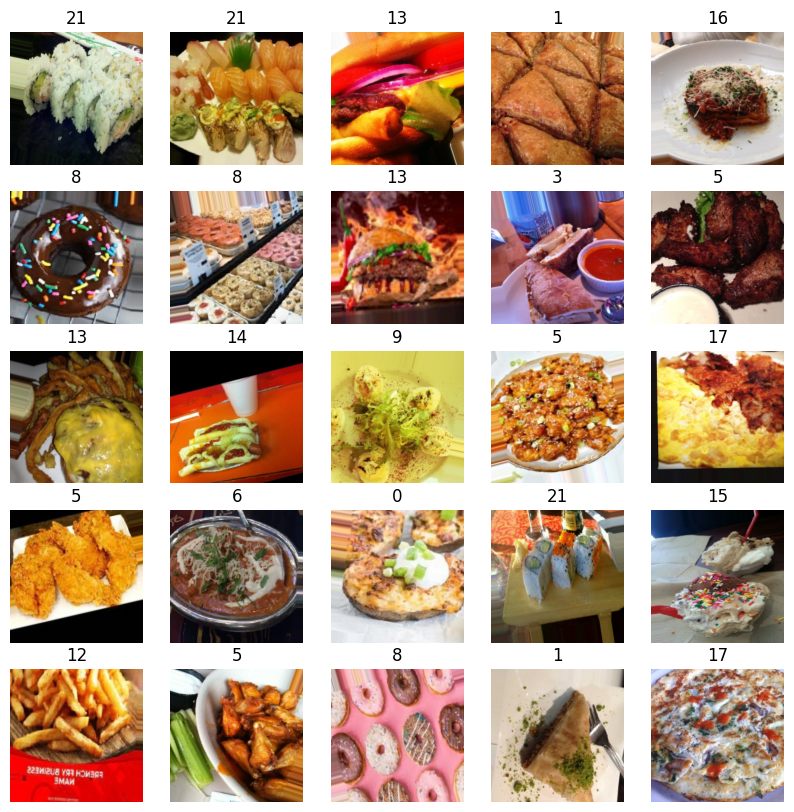

In [ ]:
batch_train_images, batch_train_labels = next(train_images)

class_names = np.argmax(batch_train_labels, axis=1)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(batch_train_images[i])
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

# VGG

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

for layer in vgg_model.layers:
    layer.trainable = False

x = Flatten()(vgg_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=predictions, name='VGG16')

model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_images,
                    steps_per_epoch=train_images.samples // batch_size,
                    epochs=10,
                    validation_data=val_images,
                    validation_steps=val_images.samples // batch_size)

Epoch 1/10
602/602 [==============================] - 305s 505ms/step - loss: 2.0565 - accuracy: 0.4228 - val_loss: 1.5870 - val_accuracy: 0.5356
Epoch 2/10
602/602 [==============================] - 303s 503ms/step - loss: 1.4944 - accuracy: 0.5543 - val_loss: 1.3745 - val_accuracy: 0.6000
Epoch 3/10
602/602 [==============================] - 287s 477ms/step - loss: 1.3536 - accuracy: 0.5959 - val_loss: 1.4016 - val_accuracy: 0.5923
Epoch 4/10
602/602 [==============================] - 286s 474ms/step - loss: 1.2662 - accuracy: 0.6199 - val_loss: 1.3292 - val_accuracy: 0.6121
Epoch 5/10
602/602 [==============================] - 306s 509ms/step - loss: 1.1998 - accuracy: 0.6411 - val_loss: 1.3842 - val_accuracy: 0.6027
Epoch 6/10
602/602 [==============================] - 306s 507ms/step - loss: 1.1630 - accuracy: 0.6462 - val_loss: 1.3169 - val_accuracy: 0.6200
Epoch 7/10
602/602 [==============================] - 290s 482ms/step - loss: 1.1309 - accuracy: 0.6554 - val_loss: 1.3412 -

In [ ]:
model.save('/content/models/vgg16', save_format='tf')

In [ ]:
val_loss, val_acc = model.evaluate(val_images, verbose=0)

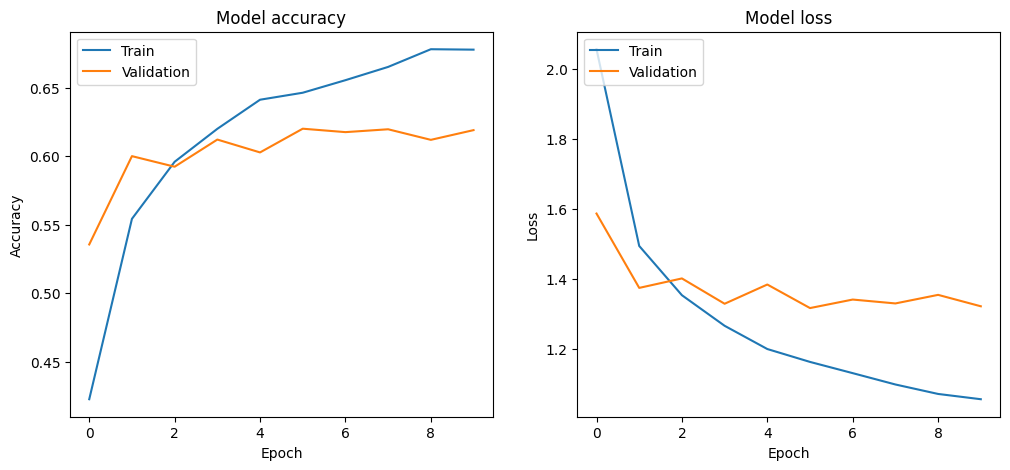

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# MobileNet

In [ ]:
pretrained_model = MobileNetV2(
    input_shape=(img_size[0], img_size[1], 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

# x = Dense(32, activation='relu')(pretrained_model.output)
# x = Dense(16, activation='relu')(x)
outputs = Dense(len(categories), activation='softmax')(pretrained_model.output)

model_mn = Model(pretrained_model.input, outputs, name='MobileNetV2')

print(model_mn.summary())

Model: "MobileNetV2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']  

In [ ]:
model_mn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    sample_weight_mode=class_weights
)

In [ ]:
history_mn = model_mn.fit(
    train_images,
    validation_data=val_images,
    epochs=3, # number of epoches are little for testing purposes
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/3
302/302 [==============================] - 288s 922ms/step - loss: 1.2767 - accuracy: 0.6348 - val_loss: 0.9094 - val_accuracy: 0.7243
Epoch 2/3
302/302 [==============================] - 265s 877ms/step - loss: 0.8430 - accuracy: 0.7502 - val_loss: 0.7875 - val_accuracy: 0.7625
Epoch 3/3
302/302 [==============================] - 264s 874ms/step - loss: 0.7569 - accuracy: 0.7739 - val_loss: 0.7614 - val_accuracy: 0.7731


In [ ]:
model_mn.save('/content/models/MobileNetV2', save_format='tf')

In [ ]:
val_loss_mn, val_acc_mn = model_mn.evaluate(val_images, verbose=0)

In [ ]:
val_loss_mn

0.7868955731391907

In [ ]:
val_acc_mn

0.7687357068061829

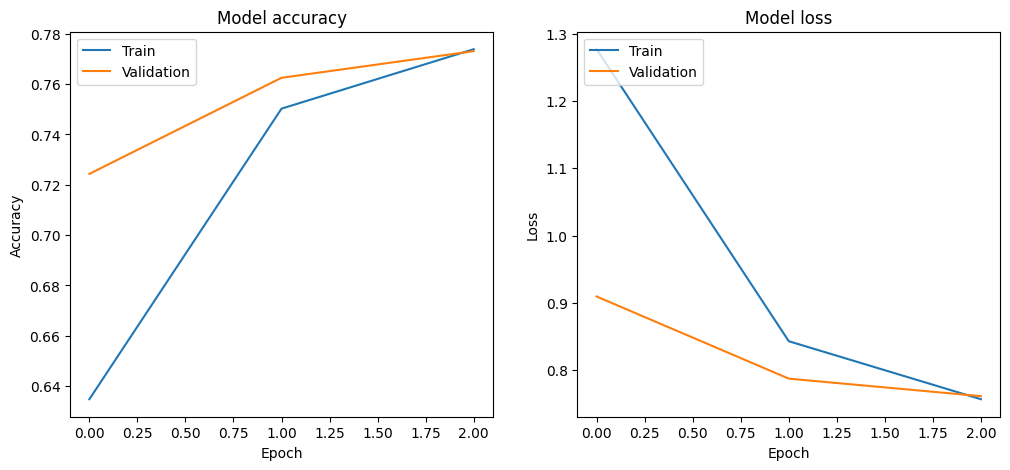

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_mn.history['accuracy'])
plt.plot(history_mn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_mn.history['loss'])
plt.plot(history_mn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
predictions = model_mn.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)

predicted_classes

76/76 [==============================] - 16s 194ms/step


array([ 8,  7,  5, ..., 12, 14, 13])

In [ ]:
true_classes = val_images.classes

In [ ]:
class_labels = list(val_images.class_indices.keys())

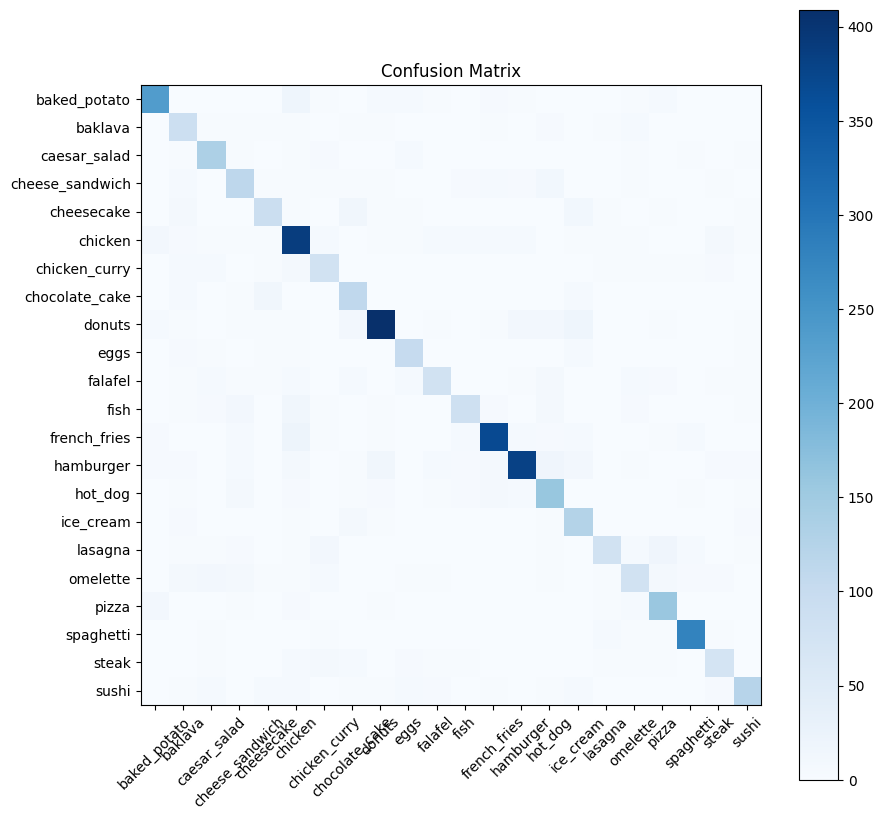

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

plt.show()

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)

                 precision    recall  f1-score   support

   baked_potato       0.87      0.82      0.84       286
        baklava       0.58      0.73      0.64       120
   caesar_salad       0.73      0.84      0.78       158
cheese_sandwich       0.64      0.67      0.65       167
     cheesecake       0.67      0.65      0.66       141
        chicken       0.78      0.84      0.81       462
  chicken_curry       0.59      0.69      0.64       115
 chocolate_cake       0.66      0.78      0.71       141
         donuts       0.89      0.84      0.87       485
           eggs       0.72      0.79      0.75       128
        falafel       0.67      0.57      0.62       136
           fish       0.75      0.60      0.67       141
   french_fries       0.90      0.83      0.86       441
      hamburger       0.90      0.80      0.85       476
        hot_dog       0.69      0.75      0.72       211
      ice_cream       0.65      0.83      0.73       152
        lasagna       0.75    

# EfficientNet